The point of this notebook is to build a custom dataset and sampler for the time series analysis we want to do. The idea is the following, we have a burst dataset much of which is nodata. Furthermore we want to load a series of these datasets into batches. Don't want to waste training on patches that are empty and want to make sure we can load this data in moderately performant way considering there is so much streaming and urls happening.

I am sure this will be improved and modified as time goes on and this represents a first attempt.

In [1]:
import geopandas as gpd
import rasterio
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from shapely.geometry import box
from rasterio.transform import xy
import pandas as pd
from tqdm import tqdm
from rasterio.windows import Window
import concurrent.futures
from dem_stitcher.geojson_io import to_geojson_gzip, read_geojson_gzip

# Burst data

In [2]:
df_rtc_meta = pd.read_json('../4_rtc_organization/rtc_s1_table.json.zip')
df_rtc_meta.head()

,rtc_s1_id,input_slc_id,jpl_burst_id,bursts_per_slc_input,rtc_s1_vv_url,rtc_s1_vh_url,rtc_s1_h5_url,acq_datetime
0,OPERA_L2_RTC-S1_T005-008688-IW2_20201010T00400...,S1A_IW_SLC__1SDV_20201010T004001_20201010T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-10 00:40:01
1,OPERA_L2_RTC-S1_T005-008688-IW2_20201022T00400...,S1A_IW_SLC__1SDV_20201022T004000_20201022T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-22 00:40:00
2,OPERA_L2_RTC-S1_T005-008688-IW2_20201103T00400...,S1A_IW_SLC__1SDV_20201103T004000_20201103T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-03 00:40:00
3,OPERA_L2_RTC-S1_T005-008688-IW2_20201115T00400...,S1A_IW_SLC__1SDV_20201115T004000_20201115T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-15 00:40:00
4,OPERA_L2_RTC-S1_T005-008688-IW2_20201127T00400...,S1A_IW_SLC__1SDV_20201127T004000_20201127T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-27 00:40:00


# For one burst

In [3]:
BURST_ID = 'T076-163099-IW1'#'T126-269585-IW2'

In [4]:
df_ts = df_rtc_meta[df_rtc_meta['jpl_burst_id'] == BURST_ID].reset_index(drop=True)
df_ts.head()

,rtc_s1_id,input_slc_id,jpl_burst_id,bursts_per_slc_input,rtc_s1_vv_url,rtc_s1_vh_url,rtc_s1_h5_url,acq_datetime
0,OPERA_L2_RTC-S1_T076-163099-IW1_20201002T22582...,S1A_IW_SLC__1SDV_20201002T225827_20201002T2258...,T076-163099-IW1,28,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-02 22:58:27
1,OPERA_L2_RTC-S1_T076-163099-IW1_20201014T22582...,S1A_IW_SLC__1SDV_20201014T225827_20201014T2258...,T076-163099-IW1,28,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-14 22:58:27
2,OPERA_L2_RTC-S1_T076-163099-IW1_20201026T22582...,S1A_IW_SLC__1SDV_20201026T225827_20201026T2258...,T076-163099-IW1,28,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-26 22:58:27
3,OPERA_L2_RTC-S1_T076-163099-IW1_20201107T22582...,S1A_IW_SLC__1SDV_20201107T225827_20201107T2258...,T076-163099-IW1,28,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-07 22:58:27
4,OPERA_L2_RTC-S1_T076-163099-IW1_20201119T22582...,S1A_IW_SLC__1SDV_20201119T225827_20201119T2258...,T076-163099-IW1,28,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-19 22:58:27


In [5]:
sample_paths = [p for p in df_ts.rtc_s1_vv_url]
sample_paths[0]

'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/RTC_S1/OPERA_L2_RTC-S1_T076-163099-IW1_20201002T225827Z_20240426T175120Z_S1A_30_v1.0/OPERA_L2_RTC-S1_T076-163099-IW1_20201002T225827Z_20240426T175120Z_S1A_30_v1.0_VV.tif'

In [6]:
with rasterio.open(sample_paths[0]) as ds:
    data_mask = ds.read_masks(1).astype(bool)
    width = ds.width
    height = ds.height
    X = ds.read(1)
    transform = ds.transform
    p = ds.profile
p['crs']

CRS.from_epsg(32719)

In [7]:
p['crs'].to_epsg()

32719

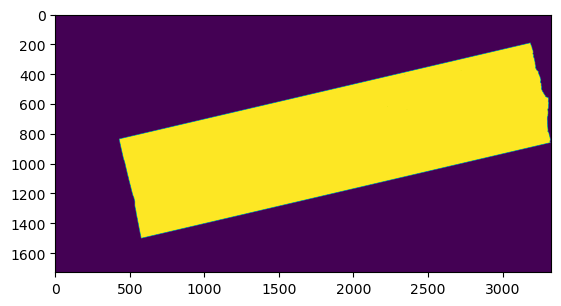

In [8]:
plt.imshow(data_mask)

In [9]:
stride = 20
patch_x = 224
patch_y = 224
percent_covered = .9
pixels_covered = patch_x * patch_y * percent_covered
pixels_covered

45158.4

In [10]:
n_x = width // stride + 1
n_y = height // stride + 1

In [11]:
slices_x = [np.s_[i * stride: i * stride + patch_x] for i in range(n_x)]
slices_y = [np.s_[i * stride: i * stride + patch_x] for i in range(n_y)]

In [12]:
patches = [(sy, sx) for sy in slices_y for sx in slices_x]
len(patches)

14529

In [13]:
data_mask.shape

(1729, 3327)

In [14]:
data_mask[np.s_[1720: 18000], np.s_[3320: 3330]].shape

(9, 7)

In [15]:
patches_with_data = [p for p in patches 
                     if (data_mask[p].sum() > pixels_covered) 
                     and (data_mask[p].shape == (patch_x, patch_y))
                    ]
len(patches_with_data)

3363

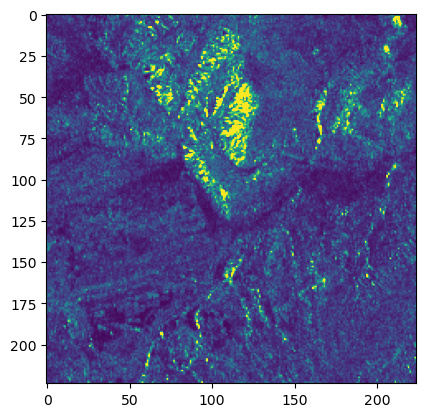

In [16]:
plt.imshow(X[patches_with_data[1_000]], vmin=0, vmax=.5)

In [17]:
patches_with_data[751]

(slice(560, 784, None), slice(1420, 1644, None))

In [18]:
def get_geo(sx, sy, transform):
    xmin, ymin = xy(transform, sy.start, sx.start)
    xmax, ymax = xy(transform, sy.stop, sx.stop)
    return box(xmin, ymin, xmax, ymax)

patch_records = [{'x_start': sx.start,
                  'x_stop': sx.stop,
                  'y_start': sy.start,
                  'y_stop': sy.stop,
                  'epsg': p['crs'].to_epsg(),
                  'burst_id': 'T064_135524_IW1',
                  'geometry': get_geo(sx, sy, transform)} for (sy, sx) in tqdm(patches_with_data)]

100%|█████████████████████████████████████████████████████████████| 3363/3363 [00:00<00:00, 14384.52it/s]


In [19]:
patch_records[0]

{'x_start': 2960,
 'x_stop': 3184,
 'y_start': 200,
 'y_stop': 424,
 'epsg': 32719,
 'burst_id': 'T064_135524_IW1',
 'geometry': <POLYGON ((772485 7465665, 772485 7458945, 765765 7458945, 765765 7465665, 7...>}

<Axes: >

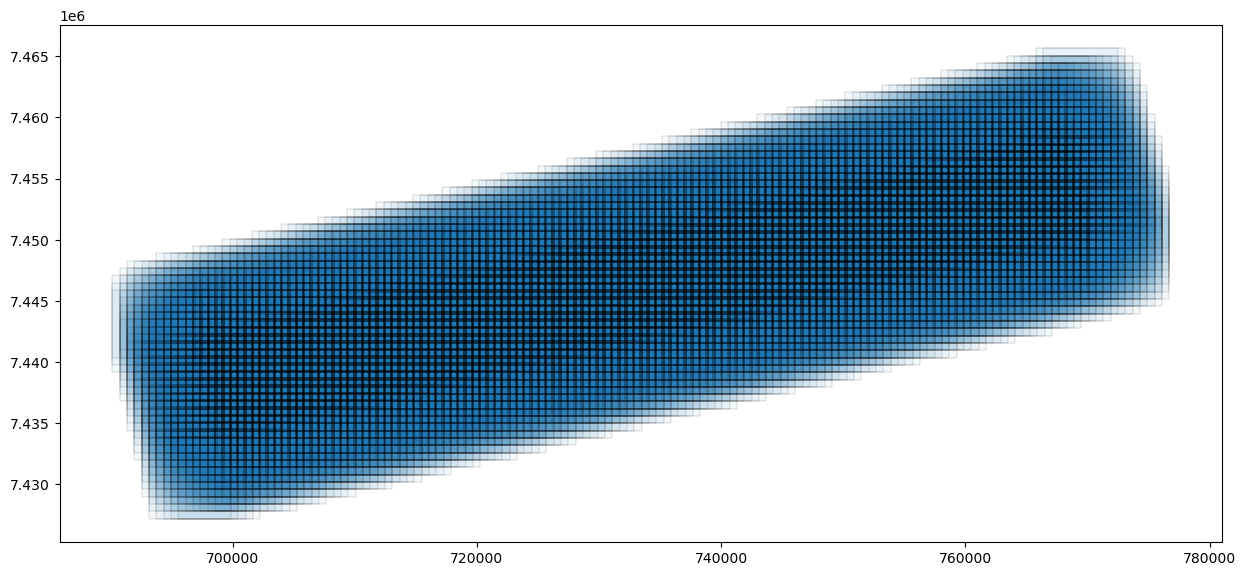

In [20]:
df_patches = gpd.GeoDataFrame(patch_records)
df_patches['patch_id'] = df_patches.index
ax = df_patches.exterior.plot(figsize=(15, 10), color='black', lw=.1, alpha=1)
df_patches.plot(figsize=(15, 10), alpha=.05, ax=ax)


# Serializing all the Bursts

In [44]:
burst_ids = df_rtc_meta.jpl_burst_id.unique()

def get_utm_geo(sx, sy, transform):
    xmin, ymin = xy(transform, sy.start, sx.start)
    xmax, ymax = xy(transform, sy.stop, sx.stop)
    return box(xmin, ymin, xmax, ymax)

def get_patch_dataframe_utm(burst_id: str, 
                            stride = 20,
                            patch_x = 224,
                            patch_y = 224,
                            percent_covered = .95,
                            serialize=True,
                            burst_patch_dir = Path('burst_patch_data_v2')) -> gpd.GeoDataFrame:
        
    burst_patch_dir = Path(burst_patch_dir)
    burst_patch_dir.mkdir(exist_ok=True, parents=True)

    out_path = burst_patch_dir / f'{burst_id}.json'

    if out_path.exists() and serialize:
        return out_path
    
    pixels_covered_per_patch = patch_x * patch_y * percent_covered
    df_ts = df_rtc_meta[df_rtc_meta['jpl_burst_id'] == burst_id].reset_index(drop=True)
    path_vv = df_ts.rtc_s1_vv_url[0]
    
    with rasterio.open(path_vv) as ds:
        data_mask = ds.read_masks(1).astype(bool)
        width = ds.width
        height = ds.height
        transform = ds.transform
        p = ds.profile
    
    n_x = width // stride + 1
    n_y = height // stride + 1
    
    slices_x = [np.s_[i * stride: i * stride + patch_x] for i in range(n_x)]
    slices_y = [np.s_[i * stride: i * stride + patch_x] for i in range(n_y)]

    patches = [(sy, sx) for sy in slices_y for sx in slices_x]
    patches_with_data = [p for p in patches if (data_mask[p].sum() > pixels_covered)
                         and (data_mask[p].shape == (patch_x, patch_y))]

    patch_records = [{'x_start': sx.start,
                      'x_stop': sx.stop,
                      'y_start': sy.start,
                      'y_stop': sy.stop,
                      #'epsg': p['crs'].to_epsg(),
                      'jpl_burst_id': burst_id,
                      #'geometry': get_geo(sx, sy, transform)
                     } for (sy, sx) in patches_with_data]

    #df = gpd.GeoDataFrame.from_dict(patch_records, crs=p['crs'])
    df = pd.DataFrame(patch_records)
    if not serialize:
        return df
    else:
        df.to_json(out_path)
        return out_path
        

In [45]:
get_patch_dataframe_utm(burst_ids[1242])

PosixPath('burst_patch_data_v2/T076-163099-IW1.json')

In [46]:
from mpire import WorkerPool

with WorkerPool(n_jobs=20, use_dill=True) as pool:
    out_paths = pool.map(
        get_patch_dataframe_utm, (bid for bid in burst_ids), 
        progress_bar=True, progress_bar_style='notebook', 
        iterable_len=len(burst_ids))

  0%|                                                                           | 0/3429 [00:00<?, ?it/s]

In [47]:
# # dfs_utm = list(map(get_patch_dataframe_utm, tqdm(burst_ids[:])))

# with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
#     out_paths = list(tqdm(executor.map(get_patch_dataframe_utm, 
#                                      burst_ids[:]), 
#                         total=len(burst_ids[:])))


# Zip Data

In [54]:
patch_data_dir = Path('burst_patch_data_v2/')
patch_data_dir.exists()

True

In [55]:
# import shutil

# shutil.make_archive('burst_patch_data_v2', 'zip', patch_data_dir)

'/u/aurora-r0/cmarshak/dist-s1-research/marshak/6_torch_dataset/burst_patch_data_v2.zip'

In [56]:
# import tarfile

# tar = tarfile.open("burst_patch_data_v2.tar.gz", "w:gz")
# tar.add("burst_patch_data_v2", arcname="burst_patch_data_v2")
# tar.close()

Does a single json make it better?

In [57]:
df_all_l = [pd.read_json(p) for p in tqdm(out_paths)]

100%|███████████████████████████████████████████████████████████████| 3429/3429 [00:25<00:00, 134.79it/s]


In [61]:
df_all_patches = pd.concat(df_all_l, axis=0)

In [62]:
compression_options = dict(method='zip', archive_name=f'patch_data_v2.json')
df_all_patches.to_json('patch_data_v2.json.zip', compression=compression_options, index=False, indent=2, orient='records')

## Checking we can stream data using our dataframe

In [50]:
df_utm = pd.read_json(out_paths[1])
utm_records = df_utm.to_dict('records')
ind = (df_rtc_meta['jpl_burst_id'] == utm_records[0]['jpl_burst_id'])
df_ts = df_rtc_meta[ind].reset_index(drop=True)

In [51]:
PATCH_IND = 30
RASTER_IND = 30

r = utm_records[PATCH_IND]
rows = [r['y_start'], r['y_stop']]
cols = [r['x_start'], r['x_stop']]
window = Window.from_slices(rows=rows, cols=cols)

with rasterio.open(df_ts.rtc_s1_vh_url[RASTER_IND]) as ds:
    X_p = ds.read(1, window=window)

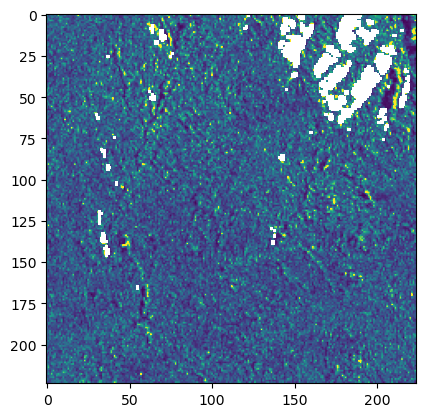

In [52]:
plt.imshow(X_p, vmin=0, vmax=.15)

## Serialize (DEPRECATED)

In [ ]:
# dfs_4326 = [df.to_crs(4326) for df in tqdm(dfs_utm)]
# df_patch = pd.concat(dfs_4326, axis=0).reset_index(drop=True)
# df_patch.head()

In [ ]:
# to_geojson_gzip(df_patch, 'dist_burst_patch.geojson.gzip')

In [ ]:
# compression_options = dict(method='zip', archive_name=f'dist_s1_patch_lut.json')
# cols = ['x_start', 'x_stop', 'y_start', 'y_stop', 'epsg', 'jpl_burst_id']
# df_patch[cols].to_json('dist_s1_patch_lut.json.zip', compression=compression_options, index=False, indent=2, orient='records')

In [32]:
# f'Total patches: {df_patch.shape[0]:,}'

In [33]:
# df_acq_per_burst = df_rtc_meta.groupby('jpl_burst_id').size().reset_index(name='acq_per_burst')
# df_patch_per_burst = df_patch.groupby('jpl_burst_id').size().reset_index(name='patch_per_burst')

# df_count = pd.merge(df_acq_per_burst, df_patch_per_burst, on='jpl_burst_id')
# df_count['total_samples'] = np.maximum(df_count['acq_per_burst'] - (4 - 1), 0) * df_count['patch_per_burst']
# df_count['total_samples_per_burst'] = np.maximum(df_count['acq_per_burst'] - (4 - 1), 0) * df_count['patch_per_burst']
# df_count['cum_samples'] = df_count['total_samples_per_burst'].cumsum()
# df_count.head()

In [34]:
# df_count.iloc[0].jpl_burst_id

In [35]:
# f'{df_count.total_samples.sum():,}'

# Custom Dataset

In [298]:
# from functools import lru_cache

# @lru_cache
# def open_rtc_table() -> pd.DataFrame:
#     return pd.read_json('../4_rtc_organization/rtc_s1_table.json.zip')

# @lru_cache
# def open_patch_table() -> pd.DataFrame:
#     return pd.read_json('dist_s1_patch_lut.json.zip')

In [ ]:
# def despeckle_one(X: np.ndarray, reg_param=2, noise_floor_db = -22) -> np.ndarray:
#     X_c = np.clip(X, 1e-7, 1)
#     X_db = 10 * np.log10(X_c, out=np.full(X_c.shape, np.nan), where=(~np.isnan(X_c)))
#     X_db[np.isnan(X_c)] = noise_floor_db
#     X_db_dspkl = bm3d.bm3d(X_db, reg_param)
#     X_dspkl = np.power(10, X_db_dspkl / 10.)
#     X_dspkl[np.isnan(X)] = np.nan
#     X_dspkl = np.clip(X_dspkl, 0, 1)
#     return X_dspkl

In [312]:
# import torch
# from torch.utils.data import Dataset
# import bisect

# def read_window(url: str,
#                 x_start,
#                 y_start,
#                 x_stop,
#                 y_stop) -> np.ndarray:
#     rows = (y_start, y_stop)
#     cols = (x_start, x_stop)
#     window = Window.from_slices(rows=rows, cols=cols)

#     with rasterio.open(url) as ds:
#         X = ds.read(1, window=window)
#     return X


# class SeqDistDataset(Dataset):
#     def __init__(self, 
#                  rtc_table: str  = None, 
#                  patch_table: str = None,
#                  n_pre_imgs = 4,
#                  transform=None):

#         self.rtc_table = rtc_table or open_rtc_table()
#         self.patch_table = patch_table or open_patch_table()
#         self.n_pre_imgs = n_pre_imgs
        
#         self.burst_ids = list(self.rtc_table.jpl_burst_id.unique())
#         self._total_samples = None
#         self._df_count = None
        
#     @property
#     def df_count(self):
#         if self._df_count is None:
#             df_acq_per_burst = df_rtc_meta.groupby('jpl_burst_id').size().reset_index(name='acq_per_burst')
#             df_patch_per_burst = df_patch.groupby('jpl_burst_id').size().reset_index(name='patch_per_burst')

#             df_count = pd.merge(df_acq_per_burst, df_patch_per_burst, on='jpl_burst_id').reset_index(drop=True)
#             df_count['total_samples_per_burst'] = np.maximum(df_count['acq_per_burst'] - self.n_pre_imgs - 1, 0) * df_count['patch_per_burst']
#             df_count['cum_samples'] = df_count['total_samples_per_burst'].cumsum()
#             self._df_count = df_count
#             return self._df_count
#         else:
#             return self._df_count
            
#     @property
#     def total_samples(self):
#         if self._total_samples is None:
#             df_count = self.df_count
#             self._total_samples = df_count['total_samples_per_burst'].sum()
#             return self._total_samples
#         else:
#             return self._total_samples

#     def acqs_per_burst(self, burst_id: str):
#         df_burst_count = self.df_count[self.df_count.jpl_burst_id == burst_id].reset_index(drop=True)
#         n = df_burst_count.iloc[0].acq_per_burst
#         return n - self.n_pre_imgs

#     def __len__(self):
#         return self.total_samples
        
#     def __getitem__(self, idx):
        
#         burst_idx = bisect.bisect_left(self.df_count.cum_samples.tolist(), idx)
        
#         burst_id = self._df_count.iloc[burst_idx].jpl_burst_id
#         acq_for_burst = self._df_count.iloc[burst_idx].acq_per_burst
#         patches_for_burst = self._df_count.iloc[burst_idx].patch_per_burst
        
#         total_samples_cum = self._df_count.iloc[burst_idx].cum_samples if burst_idx > 0 else 0
        
#         acq_idx = (idx - total_samples_cum) % acq_for_burst
#         df_ts_t = self.rtc_table[self.rtc_table.jpl_burst_id == burst_id].reset_index(drop=True)
#         # Add 1 for post image
#         df_ts = df_ts_t.iloc[acq_idx: acq_idx + self.n_pre_imgs + 1].reset_index(drop=True)

#         patch_idx = (idx - total_samples_cum) % patches_for_burst
#         patch_burst = self.patch_table[self.patch_table.jpl_burst_id == burst_id].reset_index(drop=True)
#         patch_data = patch_burst.iloc[patch_idx].to_dict()
#         def read_window_p(url: str):
#             return read_window(url, 
#                                patch_data['x_start'], patch_data['y_start'],
#                                patch_data['x_stop'], patch_data['y_stop'])
        
#         vv_data = [read_window_p(url) for url in tqdm(df_ts.rtc_s1_vv_url, desc='loading vv')]
#         vh_data = [read_window_p(url) for url in tqdm(df_ts.rtc_s1_vh_url, desc='loading vh')]

#         # A list of 2 x H X W imagery
#         acq_data = [np.stack([vv, vh], axis=0) for (vv, vh) in zip(vv_data, vh_data)]

#         # Input for modeling
#         # pre img is n_pre_imgs X 2 X H X W
#         pre_imgs = np.stack(acq_data[:self.n_pre_imgs], axis=0)
#         # post img is n_pre_imgs X 2 X H X W
#         post_img = acq_data[-1]
 
#         return {'pre_imgs': pre_imgs, 
#                 'post_img': post_img}

In [36]:
# dataset = SeqDistDataset()
# for i, data in enumerate(dataset):
#     if i > 5:
#         break
# data  